# This is a tensorflow implementation of the following paper:
[R2D2: repeatable and reliable detector and descriptor](https://europe.naverlabs.com/research/publications/r2d2-reliable-and-repeatable-detectors-and-descriptors-for-joint-sparse-local-keypoint-detection-and-feature-extraction/)




In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow_addons as tfa
import os
from skimage.util import random_noise
import sys
import time
from tqdm.notebook import tqdm
import shutil

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ZeroPadding2D, Lambda, ReLU, Input, Layer, Reshape, MaxPool2D, UpSampling2D
import tensorflow.keras.backend as K

from skimage.feature import peak_local_max
from skimage.transform import rotate
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Settings

In [2]:
PATCH_WIDTH = 256 # Patch Width
INPUT_SIZE= (PATCH_WIDTH,PATCH_WIDTH) 
BS=4 # Patch Size
ROOT_DIR="/kaggle/"

# Loading DataSet

### I was trying to make it work in presence of Speckle noise so I added Speckle noise to the input images. 


In [3]:
DATASET=os.path.join(ROOT_DIR,'input/naturalimages')
DATA_GEN_INPUT=os.path.join(ROOT_DIR,'DATASET')

if os.path.exists(DATA_GEN_INPUT):
    shutil.rmtree(DATA_GEN_INPUT)
os.mkdir(DATA_GEN_INPUT)

src=os.path.join(DATASET,"aachen")
dst=os.path.join(DATA_GEN_INPUT,"aachen")
os.symlink(src,dst)

src=os.path.join(DATASET,"revisitop1m")
dst=os.path.join(DATA_GEN_INPUT,"revisitop1m")
os.symlink(src,dst)

In [4]:
def rescale_mapping(minimum=0.,maximum=1.):
    def scaling_function(tensor):
        return tensor / 255 * (tf.abs(maximum) + tf.abs(minimum)) + minimum
    return scaling_function

def speckle_mapping(min_var=0,max_var=.4,min_val=-1.,max_val=1.):
    def add_speckle_noise(tensor):
        var = tf.random.uniform((),min_var,max_var)
        return tf.clip_by_value((tf.random.normal(tensor.shape,stddev=var) + 1.) * tensor ,min_val ,max_val)
    return add_speckle_noise

In [5]:
img_gen=tf.keras.preprocessing.image.ImageDataGenerator()
ds = tf.data.Dataset.from_generator(
    lambda : img_gen.flow_from_directory(DATA_GEN_INPUT,
                                        target_size=INPUT_SIZE,
                                        class_mode=None,
                                        color_mode='grayscale',
                                        batch_size=BS,
                                        follow_links=True,
                                        shuffle=False), 
    output_types=(tf.uint8), 
    output_shapes = ([BS,PATCH_WIDTH,PATCH_WIDTH,1])
)

In [6]:
clean_imgs = ds.map(rescale_mapping(0.,1.))

In [7]:
x = next(clean_imgs.take(1).as_numpy_iterator())

Found 21792 images belonging to 2 classes.


In [8]:
x.shape # Image size

(4, 256, 256, 1)

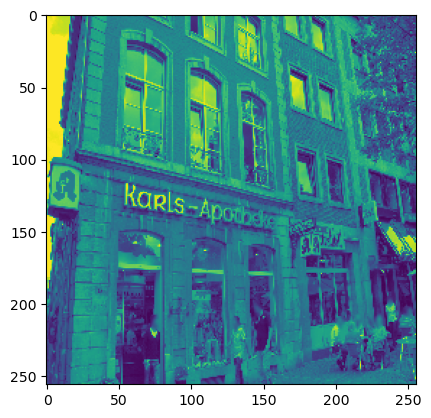

In [9]:
plt.imshow(x[0])

# Some Utility Functions Geometric transformation 

In [10]:
def scaling_matrix(cx, cy=None):
    cy = cy or cx
    transform = np.eye(3, dtype='float32')
    transform[0,0] = cx
    transform[1,1] = cy
    return tf.constant(transform)

def rotation_matrix(thetha):
    transform = np.eye(3, dtype='float32')
    transform[0,0] = np.cos(thetha)
    transform[0,1] = np.sin(thetha)
    transform[1,0] = -np.sin(thetha)
    transform[1,1] = np.cos(thetha)
    return tf.constant(transform)


def shearing_matrix(sv, sh=None):
    sh =  sh or sv
    transform = np.eye(3, dtype='float32')
    transform[1,0] = sv
    transform[0,1] = sh
    return tf.constant(transform)


def translation_matrix(tx, ty):
    transform = np.eye(3, dtype='float32')
    transform[0,2] = tx
    transform[1,2] = ty
    return tf.constant(transform)


def centered_rotation_matrix(thetha, tx, ty):
     return translation_matrix(tx,ty)@rotation_matrix(thetha)@translation_matrix(-tx,-ty)


def apply_transform(p, matrix):
    res = h @ p
    res = res / res[-1]
    return res[:2].astype('int')


def deg2rad(deg):
    return deg * np.pi / 180

# A function to generate random Affine transformations

In [11]:
def random_affine_matrix(scaling_range, rotation_range_deg, shearing_range, translation_range, image_size=(512, 512)):
    height, widht = image_size[::-1]
    scaling_min, scaling_max = scaling_range
    rotation_min, rotation_max = rotation_range_deg
    rotation_min = deg2rad(rotation_min)
    rotation_max = deg2rad(rotation_max)
    translation_min, translation_max = translation_range
    shearing_min, shearing_max = shearing_range
    scaling_mat = scaling_matrix(
        tf.random.uniform(shape=[], minval=scaling_min, maxval=scaling_max),
        tf.random.uniform(shape=[], minval=scaling_min, maxval=scaling_max)
    )

    rotation_mat = centered_rotation_matrix(
        tf.random.uniform(shape=[], minval=rotation_min, maxval=rotation_max),
        height / 2, widht / 2
    )

    translation_mat = translation_matrix(
        tf.random.uniform(shape=[], minval=translation_min, maxval=translation_max),
        tf.random.uniform(shape=[], minval=translation_min, maxval=translation_max),
    )

    shearing_mat = shearing_matrix(
        tf.random.uniform(shape=[], minval=shearing_min, maxval=shearing_max),
        tf.random.uniform(shape=[], minval=shearing_min, maxval=shearing_max),
    )

    return translation_mat @ shearing_mat @ scaling_mat @ rotation_mat

# I created a tensorflow Layer to apply random Geometric transformation on input tensors

In [12]:
class AffineTransform(tf.keras.layers.Layer):
    def __init__(self, scaling_range, rotation_range_deg, shearing_range, translation_range, batch_size=BS, **kwargs):
        self.scaling_range = scaling_range
        self.rotation_range_deg = rotation_range_deg
        self.shearing_range = shearing_range
        self.translation_range = translation_range
        self.batch_size = batch_size
        super().__init__(**kwargs)
        
    def build(self,input_shape):
        self.img_shape = input_shape[1:3]
#         self.batch_size = input_shape[0]
        super().build(input_shape)
    
    def compute_output_shape(input_shape):
        return input_shape
    
    def call(self, inputs):
#         batch_size = inputs.shape[0]
#         img_shape = inputs.shape[1:3]
        affine_mats = [
            random_affine_matrix(
                self.scaling_range, self.rotation_range_deg,
                self.shearing_range, self.translation_range, self.img_shape
            ) for _ in range(self.batch_size)]
        
#         affine_vecs = tf.concat([tf.reshape(vec, [-1])[:8][tf.newaxis] for vec in affine_mats],axis=0)
        affine_vecs = tf.reshape(affine_mats, shape=(-1,9))[:,:8]
#         tf.print(affine_vecs.shape)
        
        transformed_inputs = tfa.image.transform(inputs, affine_vecs)
        
        inverse_affine_mats = tf.linalg.inv(affine_mats)
        inverse_affine_vecs = tf.reshape(inverse_affine_mats, shape=(-1,9))[:,:8]
#         inverse_affine_vecs = tf.concat([tf.reshape(vec, [-1])[:8][tf.newaxis] for vec in inverse_affine_mats],axis=0)
        
        return transformed_inputs, inverse_affine_vecs
        

# Some more Custom Layers


In [13]:
def L2_nomlalizer():
    layer = Lambda(lambda x : tf.keras.backend.l2_normalize(x, axis=-1), name="L2NomlalizerLayer")
    return layer

def SquareLayer():
    layer = Lambda(lambda x: tf.math.square(x), name="SquareLayer")
    return layer

# This is the backbone network

In [14]:

def build_L2Net(input_shape=(256,256,1)):

    model = Sequential(name="L2Net")

    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization(epsilon=1e-5, momentum=.1, scale=False, center=False))
    model.add(ReLU())

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization(epsilon=1e-5, momentum=.1, scale=False, center=False))
    model.add(ReLU())


    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization(epsilon=1e-5, momentum=.1, scale=False, center=False))
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=2, strides=2))


    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization(epsilon=1e-5, momentum=.1, scale=False, center=False))
    model.add(ReLU())


    model.add(Conv2D(128, kernel_size=(3, 3), padding='same',dilation_rate=2))
    model.add(BatchNormalization(epsilon=1e-5, momentum=.1, scale=False, center=False))
    model.add(ReLU())
    
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same',dilation_rate=2))
    model.add(BatchNormalization(epsilon=1e-5, momentum=.1, scale=False, center=False))


    model.add(Conv2D(128, kernel_size=(2, 2), padding='same',dilation_rate=4))
    model.add(BatchNormalization(epsilon=1e-5, momentum=.1, scale=False, center=False))

    model.add(Conv2D(128, kernel_size=(2, 2), padding='same', dilation_rate=8))
#     model.add(BatchNormalization(epsilon=1e-5, scale=False, center=False))
    model.add(UpSampling2D(size=2))
#     model.add(LRN(alpha=256,k=0,beta=0.5,n=256))
    return model

# The Repeatability loss and peaky are calculated over patches of output repeatability heat map. This function here reshapes the output tensor to the desired size patches

In [15]:

@tf.function
def grid_img(img,patch_size=(256, 256), strides=(256, 256), padding="VALID"):
    p_height, p_width = patch_size
    batch_size, height, width, n_filters = img.shape
    s_height, s_width = strides
    
    p = tf.image.extract_patches(images=img,
                       sizes=[1,p_height, p_width, 1],
                       strides=[1,s_height, s_width, 1],
                       rates=[1, 1, 1, 1],
                       padding=padding)
    new_shape = list(p.shape[1:-1])+[p_height * p_width, n_filters]
    p = tf.keras.layers.Reshape(new_shape)(p)
#     p = tf.reshape(p, new_shape)
    return p
    
def GridImageLayer(patch_size=(16, 16), padding="VALID"):
    layer = Lambda(lambda x: grid_img(x, patch_size=patch_size, padding=padding), name="GridImageLayer")
    return layer

def SoftMaxPatches(ax=[-1,-2,-3]):
    layer = Lambda(lambda x: tf.keras.activations.softmax(x, axis=ax), name="SoftMaxPatches")
    return layer

# Peaky Loss

In [16]:

def peaky_loss(repeatibility, grid_size):
    pre_proc = tf.nn.avg_pool2d(repeatibility, ksize=3, strides=1, padding='SAME')
    max_pool = tf.nn.max_pool2d(pre_proc, ksize= grid_size, strides= grid_size, padding='SAME')
    avg_pool = tf.nn.avg_pool2d(pre_proc, ksize= grid_size, strides= grid_size, padding='SAME')
    loss =  1 - tf.reduce_mean(max_pool - avg_pool )
    return loss

@tf.function
def peaky_maker(tensor, grid_width=32, padding="VALID"):
    
    p = tf.image.extract_patches(images=tensor,
                   sizes=[1,grid_width, grid_width, 1],
                   strides=[1,grid_width, grid_width, 1],
                   rates=[1, 1, 1, 1],
                   padding=padding)
    p = tf.nn.softmax(p, axis=-1)
    p = tf.nn.depth_to_space(p, block_size=grid_width)
    return tf.keras.layers.Reshape(tensor.shape[1:])(p)


# Creating the Model


In [17]:
def create_base_model(back_bone_model, input_shape=(256, 256, 1), grid_size=16):
    
    inputs = tf.keras.layers.Input(shape=input_shape)
#     inputs = tf.keras.layers.GaussianNoise(stddev=0.5)(inputs)
    back_bone_output = back_bone_model(inputs)
    
    descriptor = L2_nomlalizer()(back_bone_output)
    squared_tensor = SquareLayer()(back_bone_output)
    
    x = Conv2D(2, kernel_size=(1, 1), padding='same')(squared_tensor)
    x = tf.keras.layers.Softmax(axis=[-1])(x)
    x = Conv2D(1, kernel_size=(1, 1), padding='same',name="Repeatibility")(x)
    x = tf.keras.activations.softplus(x)
    repeatibility = Lambda(lambda inputs : inputs/(inputs+1))(x)
#     repeatibility = Lambda(lambda inputs : peaky_maker(inputs, grid_width=16))(x)
    
    y = Conv2D(2, kernel_size=(1, 1), padding='same')(squared_tensor)
    y = tf.keras.layers.Softmax(axis=[-1])(y)
    y = Conv2D(1, kernel_size=(1, 1), padding='same',name="Reliability")(y)
    y = tf.keras.activations.softplus(y)
    reliability = Lambda(lambda inputs : inputs/(inputs+1))(y)
    model = tf.keras.models.Model(inputs=inputs, outputs=[repeatibility, reliability, descriptor])
    return model

In [18]:

def create_model(base_model, input_shape=(256, 256, 1), scaling_range=[.8, 1.2],
                 rotation_range_deg=[-90, 90], shearing_range=[0, .4], translation_range=[0, 64], batch_size=BS):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    transformer = AffineTransform(
        scaling_range=scaling_range, rotation_range_deg=rotation_range_deg, shearing_range=shearing_range,
        translation_range=translation_range, batch_size=batch_size
    )
    transformed_inputs, inv_affine_vecs = transformer(inputs)
    transformed_inputs = tf.keras.layers.GaussianNoise(stddev=.5)(transformed_inputs)
    repeatibility1, descriptors1 = base_model(inputs)
    repeatibility2, descriptors2 = base_model(transformed_inputs)
    inv_trans_repeatibility2 = Lambda(lambda args : tfa.image.transform(args[0], args[1]), name="InverseReapitibilityMap")((repeatibility2,inv_affine_vecs))
    inv_trans_descriptors2 = Lambda(lambda args : tfa.image.transform(args[0], args[1]), name="InverseDescriptorsMap")((descriptors2,inv_affine_vecs))
    model = tf.keras.models.Model(inputs=[inputs],outputs=[repeatibility1, repeatibility2, descriptors1, descriptors2])
    loss_repeatibility = Lambda( lambda args: repeatibility_loss(args[0], args[1], args[2]))((repeatibility1, inv_trans_repeatibility2, inv_affine_vecs))
    loss_distinctiveness = Lambda (lambda args: distinctivness_loss(args[0], args[1], args[2]))(descriptors1, inv_trans_descriptors2, inv_trans_repeatibility2)
    model.add_loss(loss_repeatibility)
    model.add_loss(loss_distinctiveness)
    return model

# For testing during training

In [19]:


def find_local_maximas(imgs, grid_size=(5,5)):
    grid_height, grid_width = grid_size
    assert grid_height%2 == 1
    assert grid_width%2 == 1
    center_indice = int((grid_height * grid_width - 1) / 2)
    imgs = tfa.image.gaussian_filter2d(imgs,filter_shape=grid_size)
#     print(center_indice)
    ksizes = [1, 1, grid_height, grid_width, 1]
    strides = [1, 1, 1, 1, 1]
    patches = tf.extract_volume_patches(imgs[tf.newaxis],ksizes,strides,"SAME")
    p1 = patches[:, :, :, :,  :center_indice]
    p2 = patches[:, :, :, :, center_indice+1:]
    max_p1 = tf.reduce_max(p1, axis=-1, keepdims=True)
    max_p2 = tf.reduce_max(p2, axis=-1, keepdims=True)
    maximums = tf.maximum(max_p1, max_p2)

    local_maxima = tf.greater(imgs, maximums)
    return local_maxima[0]


def test_model_2():
    img = cv2.imread("/kaggle/input/some-registered-images/input_0.png",0).astype('float32')/255
    img = cv2.resize(img,(256,256))
    # img_r = random_noise(rotate(img,-45), mode="speckle",var=.2)
    img_r = cv2.imread("/kaggle/input/some-registered-images/input_1.png",0).astype('float32')/255
    img_r = cv2.resize(img_r,(256,256))

    # Comparison between image_max and im to find the coordinates of local maxima
    repeatibility_1 = base_model.predict(np.expand_dims(img,axis=[0, -1]).repeat(1,0))
    repeatibility_2 = base_model.predict(np.expand_dims(img_r,axis=[0, -1]).repeat(1,0))

    coordinates = peak_local_max(repeatibility_1[0][0].squeeze(), min_distance=16)
    # coordinates_r = peak_local_max(img_r, min_distance=16)
    coordinates_r = peak_local_max(repeatibility_2[0][0].squeeze(), min_distance=16)



    # display results
    fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    mapple = ax[0, 0].imshow(img, cmap=plt.cm.gray)
    plt.colorbar(mappable=mapple, ax=ax[0, 0])
    ax[0, 0].axis('off')
    ax[0, 0].set_title('Original')

    mapple = ax[0, 1].imshow(img, cmap=plt.cm.gray)
    plt.colorbar(mappable=mapple, ax=ax[0, 1])
    ax[0, 1].autoscale(False)
    ax[0, 1].plot(coordinates[:, 1], coordinates[:, 0], 'rX')
    ax[0, 1].axis('off')
    ax[0, 1].set_title('Peak local max')
    
    mapple = ax[0, 2].imshow(repeatibility_1[0][0].squeeze())
    plt.colorbar(mappable=mapple, ax=ax[0, 2])
    ax[0, 2].autoscale(False)
    ax[0, 2].plot(coordinates[:, 1], coordinates[:, 0], 'rX')
    ax[0, 2].set_title('Peak local max')

    mapple = ax[1, 0].imshow(img_r, cmap=plt.cm.gray)
    plt.colorbar(mappable=mapple, ax=ax[1, 0])
    ax[1, 0].set_title('Original')

    mapple = ax[1, 1].imshow(img_r, cmap=plt.cm.gray)
    plt.colorbar(mappable=mapple, ax=ax[1, 1])
    
    ax[1, 1].autoscale(False)
    ax[1, 1].plot(coordinates_r[:, 1], coordinates_r[:, 0], 'rX')
    ax[1, 1].set_title('Peak local max')

    
    mapple = ax[1, 2].imshow(repeatibility_2[0][0].squeeze())
    plt.colorbar(mappable=mapple,ax=ax[1,2])
    ax[1, 2].autoscale(False)
    ax[1, 2].plot(coordinates_r[:, 1], coordinates_r[:, 0], 'rX')
    ax[1, 2].set_title('Peak local max')
    
    fig.tight_layout()
    plt.show()

# Estimation of AP for TensorFlow


In [20]:

class APLoss(tf.Module):
    def __init__(self ,nq=25, minimum=0, maximum=1, euc=False):
        self.nq = nq
        gap = maximum - minimum
        assert gap > 0
        filt = np.zeros(2*nq ,dtype='float32')
        bias = np.zeros(2*nq, dtype='float32')
        a = (nq-1)/gap
        filt[:nq] = -a 
        filt[nq:] = a
        bias[:nq] = a * minimum + np.arange(nq, 0, -1)
        bias[nq:] = np.arange(2 - nq, 2, 1) - a * minimum
        filt[0] = filt[-1] = 0
        bias[0] = bias[-1] = 1
        filt = np.expand_dims(filt, axis=[0,1])
        bias = np.expand_dims(bias, axis=[0,1])
        self.filt = tf.constant(filt)
        self.bias = tf.constant(bias)
        
    def compute_AP(self, inputs, labels):
        q = tf.nn.conv1d(inputs, self.filt,stride=1,padding="SAME") + self.bias
        q = tf.minimum(q[:, :, :, :self.nq], q[:, :, :, self.nq:])
        q = tf.where(q<0., 0., q)
        nbs = tf.reduce_sum(q, axis=-2)
#         rec = (q * tf.transpose(labels,[0,1,2,3]))
        rec = q * labels
        rec = tf.reduce_sum(rec,axis=-2)
        prec =tf.cumsum(rec, axis=-1)/(1e-16+tf.cumsum(nbs,axis=-1))
        rec /= tf.reduce_sum(rec, axis=-1,keepdims=True) + 1e-16
        ap = tf.reduce_sum(prec * rec, axis=-1)
        return ap

# Extracting Non overlapping patches


In [21]:
def extract_patches(tensor, locations, patch_width=15, keep_mask_shape=False, mask=None):
    assert patch_width % 2 == 1
    if mask is None: mask = tf.ones(shape=(patch_width, patch_width), dtype=tf.bool)
    assert len(mask.shape) == 2
    assert mask.shape[0] == mask.shape[1]
    patch_radius = tf.cast((mask.shape[0] - 1) / 2, tf.int32)
    tensor_height, tensor_width = tensor.shape[1:3]
    # coordinate_mask = (locations[:, 1]<tensor_height - patch_radius) & (locations[:, 2]<tensor_height - patch_radius) &(patch_radius<locations[:, 1]) & (patch_radius<locations[:, 2])
    # locations = locations[coordinate_mask]
    if keep_mask_shape:
        assert tf.reduce_all(mask)
        return tf.vectorized_map(lambda x:
                                 tf.reshape( \
                                     tensor[x[0], x[1] - patch_radius: x[1] + patch_radius + 1,
                                     x[2] - patch_radius: x[2] + patch_radius + 1][mask] \
                                     , (patch_width, patch_width, -1)), locations)

    else:
        return tf.vectorized_map(lambda x:
                                 tensor[x[0], x[1] - patch_radius: x[1] + patch_radius + 1,
                                 x[2] - patch_radius: x[2] + patch_radius + 1][mask], locations)

# Defining all the losses

In [22]:
peaky_loss_metric1 = tf.keras.metrics.Mean()
peaky_loss_metric2 = tf.keras.metrics.Mean()
loss_repeatibility_metric = tf.keras.metrics.Mean()
loss_confidence_metric = tf.keras.metrics.Mean()
total_loss = tf.keras.metrics.Mean()

# Training Settings

In [23]:
epochs = 3
lr = 1e-3
input_shape = (256, 256, 1)
scaling_range = [.8, 1.2]
rotation_range_deg = [-90, 90]
shearing_range = [0, .4] 
translation_range = [0, 64]
batch_size = BS
peaky_loss_grid = 32
epsilon = 1e-8
weight_decay = 5e-4
optimizer = tfa.optimizers.AdamW(learning_rate=lr,epsilon=epsilon,weight_decay=weight_decay)

In [24]:
def peaky_loss(repeatibility, grid_size):
    pre_proc = tf.nn.avg_pool2d(repeatibility, ksize=3, strides=1, padding='SAME')
    max_pool = tf.nn.max_pool2d(pre_proc, ksize= grid_size, strides= grid_size, padding='SAME')
    avg_pool = tf.nn.avg_pool2d(pre_proc, ksize= grid_size, strides= grid_size, padding='SAME')
    loss =  1 - tf.reduce_mean(max_pool - avg_pool )
    return loss



@tf.function
def grid_img(img, patch_size=(256, 256), strides=(256, 256), padding="VALID"):
    p_height, p_width = patch_size
    s_height, s_width = strides
    
    if len(img.shape) == 2:
        img = tf.expand_dims(img,axis=-1)
        channel = 1
    channel = img.shape[-1]
    p = tf.image.extract_patches(images=img,
                       sizes=[1,p_height, p_width, 1],
                       strides=[1,s_height, s_width, 1],
                       rates=[1, 1, 1, 1],
                       padding=padding)
    p = tf.reshape(p,list(p.shape[:-1])+[p_height, p_width, channel])
    # p = tf.reshape(p,[-1, p_height, p_width, channel])
    # p = tf.reshape(p,list(p.shape[:-1])+[p_height * p_width, channel])

    return p
    
def repeatibility_loss (repeatibility1, inv_trans_repeatibility2, patch_size=13, strides=11):
    masks = tf.not_equal(inv_trans_repeatibility2, 0)
    masked_repeatibility1 = tf.where(masks,repeatibility1, 0)
    rep_1 = tf.squeeze(grid_img(masked_repeatibility1, patch_size=(patch_size, patch_size), strides=(strides, strides)))
    rep_2 = tf.squeeze(grid_img(inv_trans_repeatibility2, patch_size=(patch_size, patch_size), strides=(strides, strides)))
    rep_1 = tf.keras.backend.l2_normalize(rep_1, axis=[-1, -2])
    rep_2 = tf.keras.backend.l2_normalize(rep_2, axis=[-1, -2])
    cosim = tf.reduce_sum(rep_1 * rep_2, axis=[-1, -2])
    return 1 - tf.reduce_mean(cosim)

In [ ]:

average_precision_loss = APLoss(nq=25,minimum=0,maximum=1).compute_AP


In [25]:
def extract_patches(tensor, locations, patch_width=15, keep_mask_shape=False, mask=None):
    assert patch_width % 2 == 1
    if mask is None: mask = tf.ones(shape=(patch_width, patch_width), dtype=tf.bool)
    assert len(mask.shape) == 2
    assert mask.shape[0] == mask.shape[1]
    patch_radius = tf.cast((mask.shape[0] - 1) / 2, tf.int32)
    tensor_height, tensor_width = tensor.shape[1:3]
    # coordinate_mask = (locations[:, 1]<tensor_height - patch_radius) & (locations[:, 2]<tensor_height - patch_radius) &(patch_radius<locations[:, 1]) & (patch_radius<locations[:, 2])
    # locations = locations[coordinate_mask]
    if keep_mask_shape:
        assert tf.reduce_all(mask)
        return tf.vectorized_map(lambda x:
                                 tf.reshape( \
                                     tensor[x[0], x[1] - patch_radius: x[1] + patch_radius + 1,
                                     x[2] - patch_radius: x[2] + patch_radius + 1][mask] \
                                     , (patch_width, patch_width, -1)), locations)

    else:
        return tf.vectorized_map(lambda x:
                                 tensor[x[0], x[1] - patch_radius: x[1] + patch_radius + 1,
                                 x[2] - patch_radius: x[2] + patch_radius + 1][mask], locations)


def reliability_loss_window():
    def loss_fn(x):
        central_desc, close_desc, far_desc, distractors = x
        correct_matches = tf.reduce_sum((close_desc * central_desc), axis=-1)
        labels_correct = tf.ones_like(correct_matches)
        incorrect_matches = tf.reduce_sum((far_desc * central_desc), axis=-1)
        labels_incorrect = tf.zeros_like(incorrect_matches)
        distractor_matches = tf.reduce_sum((distractors * central_desc), axis=-1)
        labels_distractors = tf.zeros_like(distractor_matches)
        # distances = tf.concat([correct_matches[None], incorrect_matches[None], distractor_matches[None]], axis=1)
        distances = tf.concat([correct_matches, incorrect_matches, distractor_matches], axis=1)
        # labels = tf.concat([labels_correct[None], labels_incorrect[None], labels_distractors[None]], axis=1)
        labels = tf.concat([labels_correct, labels_incorrect, labels_distractors], axis=1)
        distances = distances[tf.newaxis, ..., tf.newaxis]
        labels = labels[tf.newaxis, ..., tf.newaxis]
#         labels = tf.abs(labels-1)
        av_loss = average_precision_loss(distances, labels)[-1]
        return av_loss

    return loss_fn


class ReliabilityLoss():
    def __init__(self, patch_width=13, patch_division_dist=[3, 5], strides=7, img_width=256, verbose=False):
        self.patch_width = patch_width
        self.strides = strides
        self.img_width = img_width
        self.close_distance, self.far_distance = patch_division_dist
        self.verbose = verbose
        self.mask = self._gen_grid()
        self._gen_patch_indices()
        self.average_precision_loss = APLoss(nq=25, minimum=0, maximum=4).compute_AP
        self.loss_in_window = reliability_loss_window()

    def _gen_patch_indices(self):
        assert self.patch_width % 2 == 1
        radius = (self.patch_width - 1) / 2
        vector = np.arange(-radius, radius + 1)
        x, y = np.meshgrid(vector, vector)
        dists = np.sqrt(x ** 2 + y ** 2)
        self.CENTRAL_POINT_MASK = dists ==0  # this point is from the other image and it's feature added concatinated to the current feature map
        self.POSITIVE_MASK = np.logical_and(dists > 0, dists <= self.close_distance)
        self.NEGATIVE_MASK = np.logical_and(dists > self.close_distance, dists < self.far_distance)
        if self.verbose:
            plt.imshow(dists)
            plt.show()
            plt.imshow(self.CENTRAL_POINT_MASK)
            plt.show()
            plt.imshow(self.POSITIVE_MASK)
            plt.show()
            plt.imshow(self.NEGATIVE_MASK)
            plt.show()

    def _gen_grid(self):
        vector = tf.range(self.patch_width, self.img_width - self.patch_width, self.strides)
        mask = np.zeros((self.img_width, self.img_width), dtype=np.bool_)
        x, y = np.meshgrid(vector, vector)
        mask[x.flatten(), y.flatten()] = True
        mask = tf.constant(mask)
        if self.verbose:
            plt.figure(figsize=(10, 10))
            plt.imshow(mask)
            plt.show()
        return mask

    def loss_fn(self, repeatibility_map1, inv_trans_repeatibility2, reliability_map1, inv_trans_reliability_map2,
                descriptors1, inv_trans_descriptors2, k=.5):
        data_mask1 = tf.not_equal(repeatibility_map1, 0)

        data_mask2 = tf.not_equal(inv_trans_repeatibility2, 0)
        data_mask = tf.logical_and(data_mask1, data_mask2)
        sampling_mask = tf.logical_and(tf.squeeze(data_mask), self.mask)


        sampling_locs = tf.cast(tf.where(sampling_mask), tf.int32)

        features1 = tf.gather_nd(descriptors1, sampling_locs)
        features2 = tf.gather_nd(inv_trans_descriptors2, sampling_locs)
        positive_feats = extract_patches(inv_trans_descriptors2, sampling_locs,self.patch_width, mask=self.POSITIVE_MASK)
        negative_feats = extract_patches(inv_trans_descriptors2, sampling_locs,self.patch_width, mask=self.NEGATIVE_MASK)
#         positive_feats = extract_patches(descriptfeatures1ors1, sampling_locs,self.patch_width, mask=self.POSITIVE_MASK)
#         negative_feats = extract_patches(descriptors1, sampling_locs,self.patch_width, mask=self.NEGATIVE_MASK)
        central_feat = features1
        central_feat = features1[:, None, :]
        sampled_reliability = (tf.gather_nd(reliability_map1, sampling_locs) + \
                               tf.gather_nd(inv_trans_reliability_map2, sampling_locs)) / 2
        assert sampling_locs.shape[0] == positive_feats.shape[0]
        global_loss = []
        for i in tf.range(tf.reduce_max(sampling_locs[:, 0]) + 1):
            loc_features_in_batch = tf.squeeze(tf.where(sampling_locs[:, 0] == i))
            p_feat = tf.gather(positive_feats, loc_features_in_batch)
            n_feat = tf.gather(negative_feats, loc_features_in_batch)
            c_feats = tf.gather(central_feat, loc_features_in_batch)
            feat2_in_current_image = tf.gather(features2, loc_features_in_batch)
            d_feat = tf.repeat(feat2_in_current_image[None], len(feat2_in_current_image), axis=0)
            mask = tf.logical_not(tf.eye(len(feat2_in_current_image), dtype=tf.bool))
            d_feat = d_feat[mask]
            d_feat = tf.reshape(d_feat, (len(feat2_in_current_image), len(feat2_in_current_image) - 1, -1))

            loss = tf.vectorized_map(self.loss_in_window, (c_feats[:, None, :], p_feat, n_feat, d_feat))
            global_loss.append(loss)
        av = tf.concat(global_loss, axis=0)
        #This is the term you gonna need to use 
        loss = 1 - (sampled_reliability * av) - (1 - sampled_reliability) * .5
        
        #These are just some experiments
#         loss = 1 - (sampled_reliability * av)  

#         loss = (sampled_reliability - av)**2
        #         print("loss_computed")
#         loss = (sampled_reliability - tf.where(av<k ,tf.zeros_like(av),tf.ones_like(av)))**2
#         loss += tf.where(av<k, av, 1-av)
    
        return tf.reduce_mean(loss)



In [26]:
confidence_loss = ReliabilityLoss(15,[4,8], 11, verbose=False).loss_fn

In [27]:
l2_net = build_L2Net()
base_model = create_base_model(l2_net, grid_size=32)

transformer = AffineTransform(
        scaling_range=scaling_range, rotation_range_deg=rotation_range_deg, shearing_range=shearing_range,
        translation_range=translation_range, batch_size=batch_size
    )
SpeckleNoise = speckle_mapping(.05)

In [28]:
# tf.keras.utils.plot_model(base_model, expand_nested=True, show_shapes=True, )


Start of epoch 0
Found 21792 images belonging to 2 classes.


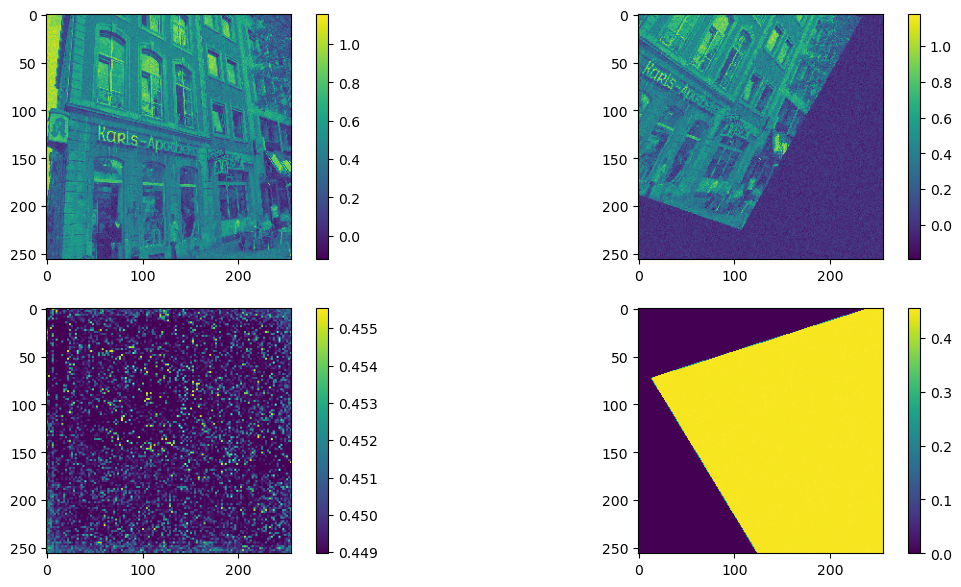

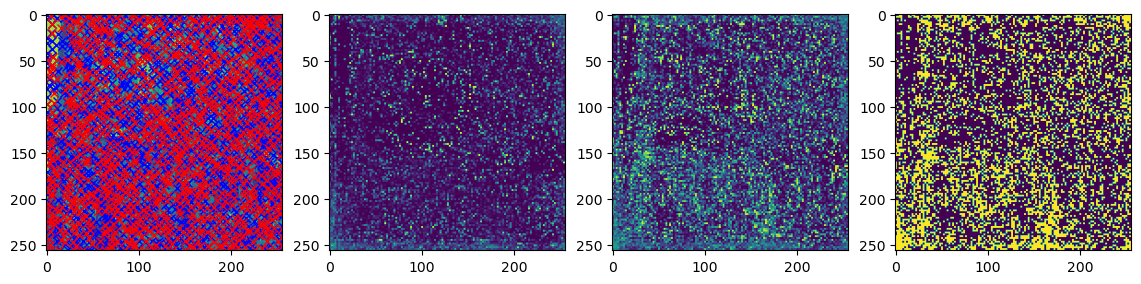

Training loss (for one batch) at step 0: 

                tolat_loss 3.4819 

                peaky_loss1 0.9970 

                peaky_loss2 0.9971 

                repeatibility_loss 0.2580 

                loss_confidence  1.2297 

                
                
Seen so far: 4 samples
1/1 [==============================] - 0s 19ms/step


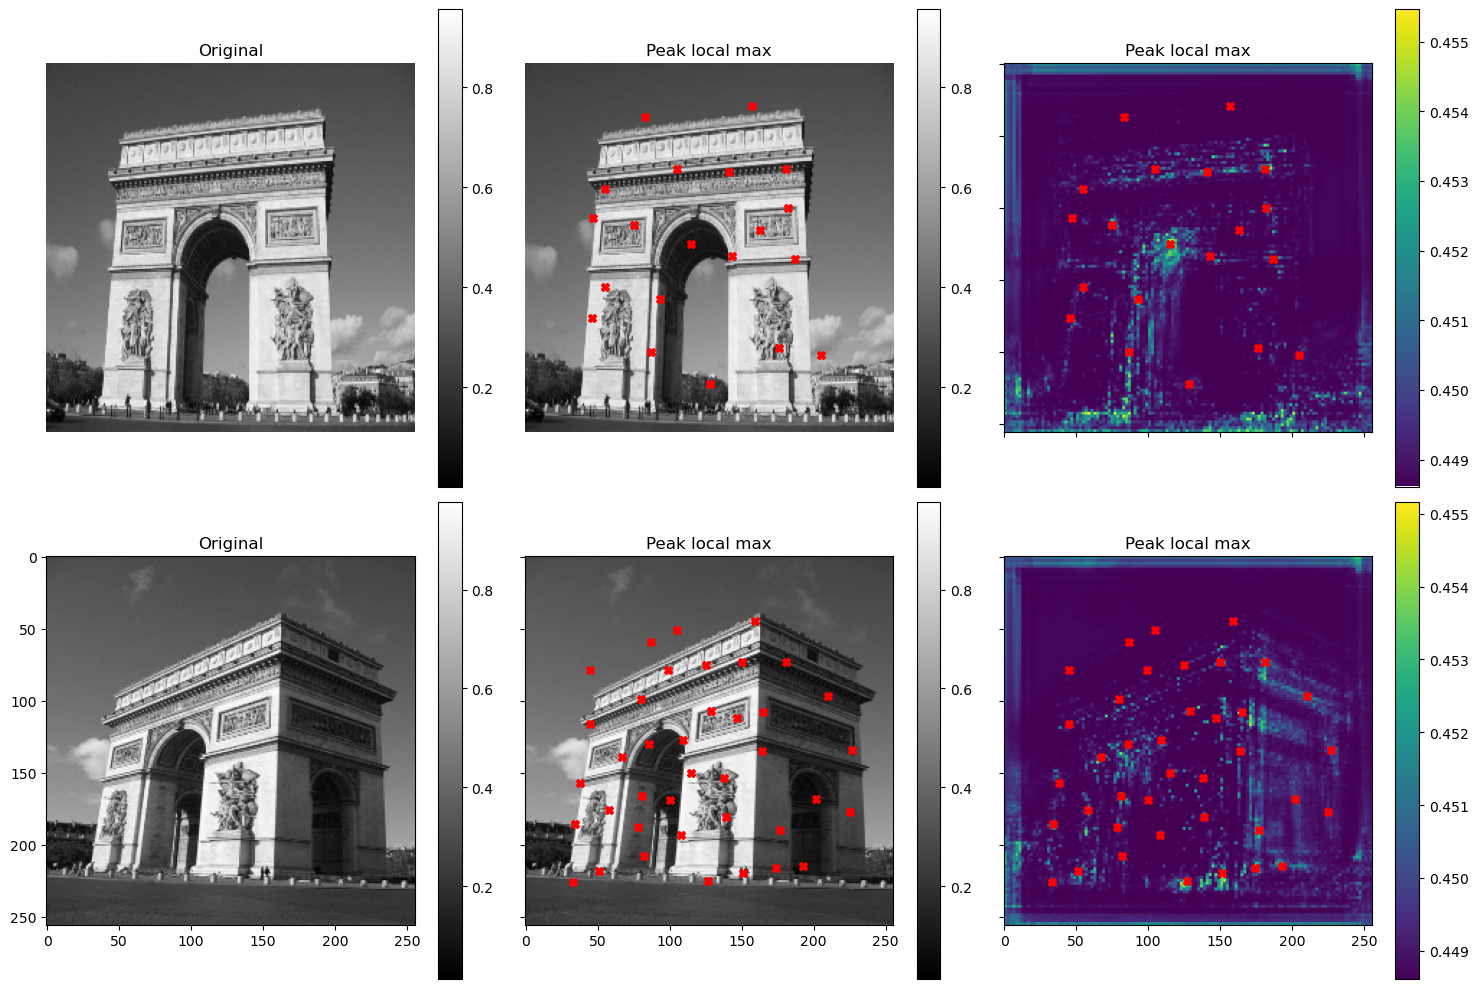

KeyboardInterrupt: 

In [29]:
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step, (inputs) in enumerate(clean_imgs):
        with tf.GradientTape() as tape:
#             inputs = SpeckleNoise(inputs)
            inputs =  tf.keras.layers.GaussianNoise(stddev=.05)(inputs,  training=True)
            transformed_inputs, inv_affine_vecs = transformer(inputs)
#             transformed_inputs = SpeckleNoise(transformed_inputs)
            transformed_inputs = tf.keras.layers.GaussianNoise(stddev=.05)(transformed_inputs,  training=True)

            repeatibility1, reliability1, descriptors1 = base_model(inputs, training=True)
            repeatibility2, reliability2, descriptors2 = base_model(transformed_inputs, training=True)

            inv_trans_repeatibility2 = tfa.image.transform(repeatibility2,inv_affine_vecs)
            inv_trans_reliability2 = tfa.image.transform(reliability2,inv_affine_vecs)
            inv_trans_descriptors2 = tfa.image.transform(descriptors2,inv_affine_vecs, interpolation='nearest')
            
            peaky_loss1 = peaky_loss(repeatibility1, peaky_loss_grid)
            peaky_loss2 = peaky_loss(repeatibility2, peaky_loss_grid)
            
            loss_repeatibility = repeatibility_loss(repeatibility1, inv_trans_repeatibility2)
#             loss_confidence = confidence_loss(repeatibility1, inv_trans_repeatibility2, reliability1, inv_trans_reliability2, descriptors1, inv_trans_descriptors2)
            
            loss_confidence_1 = confidence_loss(repeatibility1, inv_trans_repeatibility2, reliability1, inv_trans_reliability2, descriptors1, inv_trans_descriptors2)
            loss_confidence_2 = confidence_loss(inv_trans_repeatibility2, repeatibility1, inv_trans_reliability2, reliability1, inv_trans_descriptors2, descriptors1)
            loss_confidence = (loss_confidence_1 + loss_confidence_2)
            loss_value = loss_repeatibility  +  tf.reduce_sum( peaky_loss1 + peaky_loss2) + loss_confidence
#             loss_value = loss_confidence 

    
            
            peaky_loss_metric1.update_state(peaky_loss1)
            peaky_loss_metric2.update_state(peaky_loss2)
            loss_repeatibility_metric.update_state(loss_repeatibility)
            loss_confidence_metric.update_state(loss_confidence)
            total_loss.update_state(loss_value)
            
        grads = tape.gradient(loss_value, base_model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, base_model.trainable_weights))
        if step == 500:
            break
#         print("Consumed GPU Memory: ", tf.config.experimental.get_memory_usage('GPU:0')/1e9)
        
        # Log every 200 batches.
        if step % 200 == 0:
            fig, ax = plt.subplots(2, 2, figsize=(14, 7))
            mapple = ax[0, 0].imshow(inputs[0])
            plt.colorbar(mapple,ax=ax[0,0])
            mapple = ax[0, 1].imshow(transformed_inputs[0])
            plt.colorbar(mapple,ax=ax[0,1])
       
            mapple = ax[1, 0].imshow(repeatibility1[0])
            plt.colorbar(mapple,ax=ax[1,0])
            mapple = ax[1, 1].imshow(inv_trans_repeatibility2[0])
            plt.colorbar(mapple,ax=ax[1,1])
            plt.show()
            
            all_local_peaks = find_local_maximas(repeatibility1[0][tf.newaxis],(5,5))
            filtered_local_peaks = find_local_maximas(repeatibility1[0].numpy() * tf.cast((reliability1[0]>reliability1[0].numpy().mean()), tf.float32) [tf.newaxis],(5,5))
            all_pts = tf.where(all_local_peaks[0,:,:,0])
            filtered_pts = tf.where(filtered_local_peaks[0,:,:,0])
            fig, ax = plt.subplots(1,4,figsize=(14,7))
            ax[0].imshow(inputs[0])
            ax[0].plot(all_pts[:, 1],all_pts[:, 0],'bx')
            ax[0].plot(filtered_pts[:, 1],filtered_pts[:, 0],'rx')
            
            
            ax[1].imshow(repeatibility1[0])
#             ax[1].plot(locs[:, 1],locs[:, 0],'rx')
            mapple = ax[2].imshow(reliability1[0])
            mapple = ax[3].imshow(reliability1[0]>reliability1[0].numpy().mean())
#             mapple = ax[2].imshow(reliability1[0])
            
#             plt.colorbar(mapple,ax=ax[2])
            plt.show()
            
            print(
                """Training loss (for one batch) at step %d: \n
                tolat_loss %.4f \n
                peaky_loss1 %.4f \n
                peaky_loss2 %.4f \n
                repeatibility_loss %.4f \n
                loss_confidence  %.4f \n
                
                """ % (step, float(total_loss.result()), float(peaky_loss_metric1.result()),
                       float(peaky_loss_metric2.result()), float(loss_repeatibility_metric.result()),
                       float(loss_confidence_metric.result())
                      )
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
            test_model_2()
            
            peaky_loss_metric1.reset_states()
            peaky_loss_metric2.reset_states()
            loss_repeatibility_metric.reset_states()
            loss_confidence_metric.reset_states()
            total_loss.reset_states()

# Now let's test it

In [ ]:

def find_keypoints(img1 ,img2, heat_map1, heat_map2, min_dist=10, threshold_rel=.9,plot_results=False):

    coordinates1 = peak_local_max(heat_map1, min_distance=min_dist, threshold_rel=threshold_rel)
    coordinates2 = peak_local_max(heat_map2, min_distance=min_dist, threshold_rel=threshold_rel)
    kp1 = to_opencv_keypoints(coordinates1.astype('float32'))
    kp2 = to_opencv_keypoints(coordinates2.astype('float32'))
    if plot_results == False:
        return kp1, kp2, coordinates1, coordinates2
    
    # display results
    fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    ax[0, 0].imshow(img1, cmap=plt.cm.gray)
    ax[0, 0].axis('off')
    ax[0, 0].set_title('Original')

    ax[0, 1].imshow(img1, cmap=plt.cm.gray)
    ax[0, 1].autoscale(False)
    ax[0, 1].plot(coordinates1[:, 1], coordinates1[:, 0], 'rX')
    ax[0, 1].axis('off')
    ax[0, 1].set_title('Peak local max')
    
    mapple = ax[0, 2].imshow(heat_map1)
    plt.colorbar(mappable=mapple, ax=ax[0, 2])
    ax[0, 2].autoscale(False)
    ax[0, 2].plot(coordinates1[:, 1], coordinates1[:, 0], 'rX')
    ax[0, 2].set_title('Peak local max')

    ax[1, 0].imshow(img2, cmap=plt.cm.gray)
    ax[1, 0].set_title('Original')

    ax[1, 1].imshow(img2, cmap=plt.cm.gray)
    ax[1, 1].autoscale(False)
    ax[1, 1].plot(coordinates2[:, 1], coordinates2[:, 0], 'rX')
    ax[1, 1].set_title('Peak local max')

    
    mapple = ax[1, 2].imshow(heat_map2)
    plt.colorbar(mappable=mapple,ax=ax[1,2])
    ax[1, 2].autoscale(False)
    ax[1, 2].plot(coordinates2[:, 1], coordinates2[:, 0], 'rX')
    ax[1, 2].set_title('Peak local max')
    
    fig.tight_layout()
    plt.show()
    
    return kp1, kp2, coordinates1, coordinates2
    
def get_features(input_image,weight_path="R2D2_MyImplementation_v1.h5"):
    img =input_image.astype('float32')/255
    assert img.ndim == 2
    shape = list(img.shape)+[1]
    print(shape)
    img = np.expand_dims(img,axis=[0,-1])
    batch = img.repeat(2,axis=0)
    lnet2 = build_L2Net(shape)
    model = create_base_model(lnet2,input_shape=shape)
    model.load_weights(weight_path)
    heat_map, _, descriptors = model.predict(batch)
    return heat_map[0].squeeze(), descriptors[0]
    

def to_opencv_keypoints(keypoints,size_scale=20):
    converterd_keypoints=[]
    for y, x in keypoints:
        k=cv2.KeyPoint(x=x, y=y, size=size_scale, angle=0, octave=int(size_scale))
        converterd_keypoints.append(k)
    return converterd_keypoints

In [ ]:
img1 = cv2.imread("/kaggle/input/some-registered-images/a1.jpg", 0)
img2 = cv2.imread("/kaggle/input/some-registered-images/a2.jpg", 0)

In [ ]:
saved_model = "R2D2.h5"
base_model.save_weights(saved_model)

In [ ]:
heat_map1, descriptors1 = get_features(img1, saved_model)
heat_map2, descriptors2 = get_features(img2, saved_model)

In [ ]:
kp1, kp2, c1, c2 = find_keypoints(img1, img2, heat_map1, heat_map2,min_dist=8 ,threshold_rel=.99, plot_results=True)

In [ ]:
desc1 = np.array([descriptors1[m,n] for m, n in c1])
desc2 = np.array([descriptors2[m,n] for m, n in c2])
# desc1 = np.array([descriptors1[n,m] for m, n in c1])
# desc2 = np.array([descriptors2[n,m] for m, n in c2])

In [ ]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1,desc2, k=2)

# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good_matches.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,outImg=None,flags=2)
plt.figure(figsize=(20,18))
plt.imshow(img3)

In [ ]:
pt1=[c1[m[0].queryIdx][:2][::-1] for m in good_matches ]
pt2=[c2[m[0].trainIdx][:2][::-1] for m in good_matches ]
pt1=np.array(pt1)
pt2=np.array(pt2)

In [ ]:
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, rotate,AffineTransform


In [ ]:
transformation_model, mask = ransac(
    (pt1, pt2),
    AffineTransform, min_samples=3,
    residual_threshold=3,  max_trials=10000
)

In [ ]:
def translatePoint(p, d):
    x, y = p
    dx, dy = d
    return [x + dx, y + dy]


def homographyTransform(h,p):
    res=h@p
    res=res/res[-1]
    return res[:2].astype('int')



def drawMatches(pt1, img1, pt2, img2, mask, h_mat):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img = np.zeros(shape=(max(h1, h2), w1 + w2), dtype='uint8')
    img[:h1, :w1] = img1
    img[:h2, w1:] = img2
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    x = []
    x.append([0, 0, 1])
    x.append([w1, 0, 1])
    x.append([w1, h1, 1])
    x.append([0, h1, 1])

    tx = [translatePoint(homographyTransform(h_mat, np.array(p)), (w1, 0)) for p in x]
    tx = np.array([tx])
    for i, m in enumerate(mask):
        if m == 1:
            dst = (int(w1 + pt2[i][0]), int(pt2[i][1]))
            src = (int(pt1[i][0]), int(pt1[i][1]))
            #             color=tuple(np.random.randint(0,255,3,dtype='int'))
            color = np.random.randint(0, 255, size=(3), dtype=np.uint8)
            color = (int(color[0]), int(color[1]), int(color[2]))
            cv2.line(img, src, dst, color, thickness=1)
    cv2.polylines(img, tx, isClosed=True, color=color, thickness=2)
    plt.figure(figsize=(20, 18))
    plt.imshow(img)
    plt.show()
    return img

In [ ]:
imgg=drawMatches(pt1,img1,pt2,img2,mask,transformation_model.params)

In [ ]:
img=cv2.warpPerspective(img1,transformation_model.params,img2.shape[::-1])

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,18))
ax[0].imshow(img)
ax[1].imshow(img2)

In [ ]:
def homographyAddTranslation(h, translation):
    h_t = np.eye(3)
    h_t[0, 2] = translation[1]
    h_t[1, 2] = translation[0]
    return h_t @ h

def crop_image(img,percentile=.6):
    height,width=img.shape[:2]
    h=int(percentile*height/2)
    w=int(percentile*width/2)
    return img[h:-h,w:-w]

def grid_img(img,grid_size=60):
    data=img.copy()
    h,w=img.shape[:2]
    n_h=h//grid_size
    n_w=w//grid_size
    skip=-1
    for m in range(n_h-1):
        for n in range(n_w-1):
            skip*=-1
            if skip==1:
                data[m*grid_size:(m+1)*grid_size,n*grid_size:(n+1)*grid_size]=0
    return data
def stichImages(img1, img2, h):
    dst_h, dst_w = img2.shape[:2]
    dst_shape = (dst_w * 3, dst_h * 3)
    h = homographyAddTranslation(h, (dst_h, dst_w))
    img = cv2.warpPerspective(img1, h, dst_shape)
#     fig, ax = plt.subplots(1, 2, figsize=(20, 18))
    padded_img = np.pad(img2, [[dst_h, dst_h], [dst_w, dst_w]])
#     ax[0].imshow(img)
#     ax[1].imshow(padded_img)
#     plt.show()
    img_registeded = padded_img.copy()
    img=grid_img(img)
    img_registeded[img != 0] = img[img != 0]
    img_registeded=crop_image(img_registeded)
    plt.figure(figsize=(14, 10))
    plt.imshow(img_registeded)
    plt.show()
    return 

In [ ]:
img_registeded = stichImages(img1, img2, transformation_model.params)
